In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output

import numpy as np
import pylab as pl

from src import *

In [2]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 8     # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5

torch.backends.cudnn.benchmark = True # Speeds up things

In [3]:
# Starting state

def generator(n_images):
    return make_seed(n_images, N_CHANNELS, IMAGE_SIZE, n_CAs=1)

pool = SamplePool(POOL_SIZE, generator)

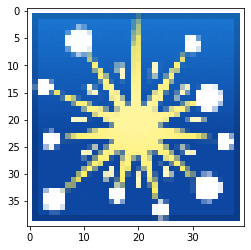

In [4]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

model = MultipleCA(N_CHANNELS, n_CAs=1, device=device)

In [6]:
model.CAs[0].load("Multiple_CA_growing_0.pt")

Successfully loaded model!


In [6]:
params = model.CAs[0].parameters()

optimizer = torch.optim.Adam(params, lr=2e-3)
criterion = NCALoss(pad(target, TARGET_PADDING), torch.nn.MSELoss, alpha_channels=[15])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)

model.train_CA(optimizer, criterion, pool, n_epochs=300, skip_update=1, batch_size=4,
               scheduler=scheduler, kind="growing", skip_damage=1)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.95 GiB total capacity; 1.25 GiB already allocated; 13.62 MiB free; 1.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

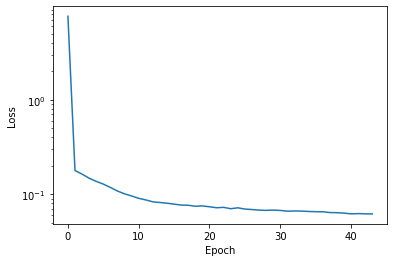

In [8]:
pl.plot(model.losses)
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.yscale("log")
pl.show()
# pl.savefig(fname="perturbation_regeneration_l=1_side=20_losses.png", dpi=200)

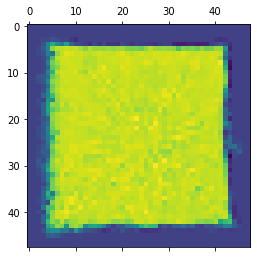

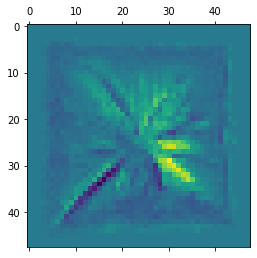

In [20]:
pl.matshow(inputs[0, -1].cpu())
pl.matshow(inputs[0, -4].cpu())

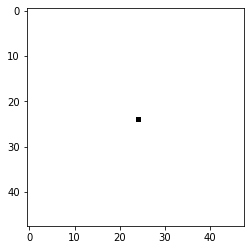

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


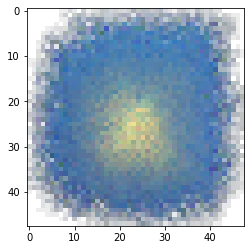

In [7]:
def state_to_image(x, n_channels, mask_channels):
    alpha = x[:, n_channels-1:n_channels-1+mask_channels].sum(dim=1).unsqueeze(1)
    return torch.cat((x[:, :3], alpha), dim=1)


inputs = pool.sample(2)[0].cuda()

imshow(inputs[0, [0,1,2,-1]].detach())
# recursive forward-pass
inputs = model.evolve(inputs, 60)

imshow(inputs[0, [0,1,2,-1]].detach())

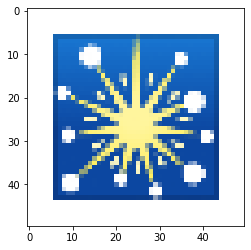

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))